In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import chi2_contingency
import math
from collections import Counter
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import inf
from sklearn.model_selection import GridSearchCV



In [2]:
# Load the train and test datasets
Xtrain_scaled = np.load('Xtrain_scaled.npy')
Xtest_scaled = np.load('Xtest_scaled.npy')
Xtrainb_scaled = np.load('Xtrainb_scaled.npy')
Xtestb_scaled = np.load('Xtestb_scaled.npy')
ytrain = np.load('ytrain.npy')
ytest = np.load('ytest.npy')
df_train = pd.read_csv('../../../Data/paths_AOA_trainData.csv')
df_test = pd.read_csv('../../../Data/paths_AOA_testData.csv')


In [3]:

id_cols = ['id', 'client_id']

demo_cols = ['age', 'age_group','race','gender','dx_group','lang', 'substance','insurance','emp', 'educ','liv','justice', 'sexorient', 'co']

ip_cols = ['as_loc', 'as_length_IP', 'IP_history', 'as_close']

loc_pre_cols = ['loc1_pre', 'loc2_pre', 'loc3_pre', 'loc4_pre', 'loc5_pre']

svc_total_pre_cols = ['new','svc_pre_all', 'svc_pre', 'svc_pre_sub']

svc_AOA_timepoint_pre_cols = ['svc_AOA_op_7days_pre', 'svc_AOA_op_30days_pre', 'svc_AOA_op_60days_pre', 'svc_AOA_op_90days_pre',
                     'svc_AOA_es_7days_pre', 'svc_AOA_es_30days_pre', 'svc_AOA_es_60days_pre', 'svc_AOA_es_90days_pre',
                     'svc_AOA_24h_7days_pre', 'svc_AOA_24h_30days_pre', 'svc_AOA_24h_60days_pre', 'svc_AOA_24h_90days_pre',
                     'svc_AOA_ip_7days_pre', 'svc_AOA_ip_30days_pre', 'svc_AOA_ip_60days_pre', 'svc_AOA_ip_90days_pre']

output_col = ['svc_AOA_ip_30days_postdc_bi']

drop_cols = ['']

In [4]:
numerical_features = ['age', 'as_length_IP', 'IP_history', 'svc_pre_all', 'svc_pre', 'svc_pre_sub']
numerical_features = numerical_features  + svc_AOA_timepoint_pre_cols
dummy_vars = df_train.loc[:, 'age_group_Age 60+':'loc5_pre_WRAP']
dummy_vars = list(dummy_vars.columns)
categorical_features = dummy_vars + ['co', 'substance', 'justice']
all_features = numerical_features + categorical_features

boruta_features = ['as_length_IP', 'IP_history', 'svc_pre_all', 'svc_pre', 'svc_AOA_ip_30days_pre', 'svc_AOA_ip_60days_pre', 'dx_group_Depressive Disorders', 'dx_group_Schizophrenia and Other Psychotic Disorders', 'educ_Unknown/Not Reported', 'sexorient_Missing/Not Reported', 'as_loc_IPFFS', 'as_loc_IPLIHP', 'as_close_IMD/MHRC', 'as_close_Psychiatric Hospital', 'loc1_pre_None', 'co', 'as_close_Required Lower Level\r\nof Care']

In [5]:
Xtrain = df_train[all_features]
Xtrainb = df_train[boruta_features]

In [6]:
# Set a seed for reproducibility
SEED = 300
np.random.seed(SEED)

In [7]:
print(np.any(np.isnan(Xtrain_scaled)))
print(np.any(np.isnan(ytrain)))
#np.all(np.isfinite(Xtrain_scaled))

False
False


In [8]:
print(np.any(np.isnan(Xtest_scaled)))
print(np.any(np.isnan(ytest)))

False
False


### Fit all variables into the models

In [9]:
# import datetime
from datetime import datetime

# import a host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# import model metrics
from sklearn.metrics import *


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=1, random_state=SEED, solver='liblinear', class_weight='balanced')
    nn = MLPClassifier((100, 50), early_stopping=True, random_state=SEED, max_iter=400, activation='tanh')
    dt = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')
    rf = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced')
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    
    models = {'naive bayes': nb,
              'knn': knn,
              'logistic': lr,
              'mlp-nn': nn,
              'decision tree': dt,
              'random forest': rf,
              'gbm': gb
             }


    return models


def train_predict(model_list, xtrain, ytrain, xtest):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    S = np.zeros((ytest.shape[0], len(model_list)))
    S = pd.DataFrame(S)
    
    print("Fitting models.")
    cols = list()
    model_cvs = {}

    for i, (name, m) in enumerate(models.items()):
        current_time = datetime.now() 
        print("%s..." % name, end=" ", flush=False)
        model_cvs[name] = m.fit(xtrain, ytrain)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        S.iloc[:, i] = m.predict(xtest)
        cols.append(name)
        time_elapsed = datetime.now() - current_time
        print("Time elapsed ", time_elapsed)
        print("done")

    P.columns = cols
    S.columns = cols
    
    print("Done.\n")
    return P, S, model_cvs

    
def evaluate(y_true, S, P):
    for m in P.columns:
        y_pred = S.loc[:, m]
        y_pred_proba = P.loc[:, m]
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1score = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred_proba)
        ap = average_precision_score(y_true, y_pred_proba)
        print ("Accuracy : {:.4f}".format(acc))
        print("Precision : {:.4f}".format(precision))
        print("Recall : {:.4f}".format(recall))
        print("F1 score : {:.4f}".format(f1score))
        print("AUC score : {:.4f}".format(auc))
        print("AP score : {:.4f}".format(ap))
        print("\nClassification report : \n", classification_report(y_true, y_pred))
        print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))
        print("done.\n")  
    return acc, precision, recall, f1score, auc, ap

In [10]:
models = get_models()
P, S, model_cvs = train_predict(models, Xtrain_scaled, ytrain, Xtest_scaled)
evaluate(ytest, S, P)

Fitting models.
naive bayes... Time elapsed  0:00:00.895631
done
knn... Time elapsed  0:01:03.812228
done
logistic... Time elapsed  0:00:05.824112
done
mlp-nn... Time elapsed  0:02:27.465438
done
decision tree... Time elapsed  0:00:09.915411
done
random forest... Time elapsed  0:00:54.200868
done
gbm... Time elapsed  0:04:28.550427
done
Done.

Accuracy : 0.3028
Precision : 0.2734
Recall : 0.9601
F1 score : 0.4257
AUC score : 0.5118
AP score : 0.2739

Classification report : 
               precision    recall  f1-score   support

           0       0.81      0.06      0.11     15338
           1       0.27      0.96      0.43      5646

    accuracy                           0.30     20984
   macro avg       0.54      0.51      0.27     20984
weighted avg       0.66      0.30      0.20     20984


Confusion matrix : 
 [[  934 14404]
 [  225  5421]]
done.

Accuracy : 0.5945
Precision : 0.3526
Recall : 0.6066
F1 score : 0.4460
AUC score : 0.6252
AP score : 0.3460

Classification report :

(0.7703488372093024,
 0.6057815298030187,
 0.41941197307828554,
 0.4956567242281529,
 0.7663422921185516,
 0.5950459187115562)

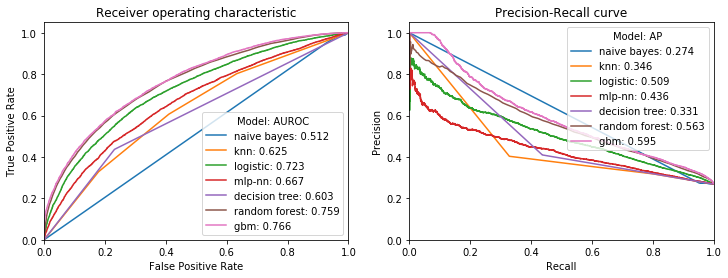

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in P.columns:
    roc_auc = roc_auc_score(ytest, P[column])
    fpr, tpr, _ = roc_curve(ytest, P[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, P[column])
    ave_prec_rec = average_precision_score(ytest, P[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

In [12]:
lr_importances = pd.Series(model_cvs['logistic'].coef_[0], index=Xtrain.columns, name = 'LR')
lr_importances_abs = pd.Series(abs(model_cvs['logistic'].coef_[0]), index=Xtrain.columns, name = 'LR')
print("Top 15 features")
print(lr_importances.nlargest(15))

Top 15 features
IP_history                                 4.517784
svc_AOA_ip_90days_pre                      2.177049
as_close_State Hospital                    1.820248
as_close_Psychiatric Hospital              1.696303
as_close_Required Same Level\r\nof Care    1.678694
svc_AOA_ip_30days_pre                      1.511590
loc5_pre_IPCAPS                            1.461222
loc5_pre_CM                                1.207153
svc_AOA_es_30days_pre                      1.204826
as_close_Medical Hospital                  1.172626
loc1_pre_DTCTF                             1.167332
as_close_Transfer Medical Hospital         1.133891
svc_AOA_es_90days_pre                      1.007336
loc2_pre_LTC                               0.963551
loc3_pre_LTCINST                           0.935012
Name: LR, dtype: float64


In [13]:
dt_importances = pd.Series(model_cvs['decision tree'].feature_importances_, index=Xtrain.columns, name = 'DT')
print("Top 15 features")
print(dt_importances.nlargest(15))

Top 15 features
svc_AOA_ip_90days_pre             0.226786
IP_history                        0.129421
as_length_IP                      0.119105
age                               0.039316
svc_pre_all                       0.036490
svc_pre_sub                       0.031336
svc_pre                           0.022522
svc_AOA_es_90days_pre             0.015232
svc_AOA_ip_30days_pre             0.015007
svc_AOA_op_90days_pre             0.011307
svc_AOA_es_60days_pre             0.010428
svc_AOA_es_30days_pre             0.010257
svc_AOA_op_60days_pre             0.009308
svc_AOA_op_30days_pre             0.009037
sexorient_Missing/Not Reported    0.008843
Name: DT, dtype: float64


In [14]:
rf_importances = pd.Series(model_cvs['random forest'].feature_importances_, index=Xtrain.columns, name = 'RF')
print("Top 15 features")
print(rf_importances.nlargest(15))

Top 15 features
as_length_IP                      0.070181
IP_history                        0.064907
svc_AOA_ip_90days_pre             0.047191
svc_AOA_ip_60days_pre             0.044932
svc_pre_all                       0.041155
age                               0.039472
svc_AOA_ip_30days_pre             0.031693
svc_pre                           0.029881
svc_AOA_es_90days_pre             0.024439
svc_AOA_es_60days_pre             0.021524
svc_pre_sub                       0.021259
svc_AOA_op_60days_pre             0.020538
svc_AOA_op_90days_pre             0.019788
svc_AOA_es_30days_pre             0.016910
sexorient_Missing/Not Reported    0.016815
Name: RF, dtype: float64


In [15]:
gbm_importances = pd.Series(model_cvs['gbm'].feature_importances_, index=Xtrain.columns, name = 'GBM')
print("Top 15 features")
print(gbm_importances.nlargest(15))

Top 15 features
svc_AOA_ip_90days_pre                                   0.250151
IP_history                                              0.189141
as_length_IP                                            0.135611
svc_AOA_ip_60days_pre                                   0.063773
svc_AOA_ip_30days_pre                                   0.058893
svc_pre_sub                                             0.052309
sexorient_Missing/Not Reported                          0.034727
gender_Male                                             0.025144
liv_Lives Independently                                 0.020173
as_close_Home/Shelter/Self                              0.020148
svc_AOA_es_90days_pre                                   0.015178
dx_group_Schizophrenia and Other Psychotic Disorders    0.011173
dx_group_Depressive Disorders                           0.010821
as_close_Psychiatric Hospital                           0.010445
as_close_IMD/MHRC                                       0.010064
Name: GBM

In [16]:
importances_df = pd.concat([lr_importances, dt_importances, rf_importances, gbm_importances], axis=1)
importances_df['avg'] = importances_df[['DT', 'RF', 'GBM']].mean(axis=1)
importances_df = importances_df.sort_values(by='avg', ascending=False)
importances_df.reset_index(inplace=True)
importances_df = importances_df.rename(columns = {'index':'Variable'})
importances_df.head(15)

,Variable,LR,DT,RF,GBM,avg
0,svc_AOA_ip_90days_pre,2.177049,0.226786,0.047191,0.250151,0.174709
1,IP_history,4.517784,0.129421,0.064907,0.189141,0.127823
2,as_length_IP,-4.143072,0.119105,0.070181,0.135611,0.108299
3,svc_AOA_ip_60days_pre,0.274370,0.004017,0.044932,0.063773,0.037574
4,svc_AOA_ip_30days_pre,1.511590,0.015007,0.031693,0.058893,0.035197
5,svc_pre_sub,-0.374770,0.031336,0.021259,0.052309,0.034968
6,age,-0.636074,0.039316,0.039472,0.002075,0.026954
7,svc_pre_all,-1.691778,0.036490,0.041155,0.000055,0.025900
8,sexorient_Missing/Not Reported,-0.349230,0.008843,0.016815,0.034727,0.020128
9,svc_AOA_es_90days_pre,1.007336,0.015232,0.024439,0.015178,0.018283


In [17]:
# Select the top 15 variables
important_vars = list(importances_df.iloc[0:15,0])
important_vars

['svc_AOA_ip_90days_pre',
 'IP_history',
 'as_length_IP',
 'svc_AOA_ip_60days_pre',
 'svc_AOA_ip_30days_pre',
 'svc_pre_sub',
 'age',
 'svc_pre_all',
 'sexorient_Missing/Not Reported',
 'svc_AOA_es_90days_pre',
 'svc_pre',
 'gender_Male',
 'liv_Lives Independently',
 'as_close_Home/Shelter/Self',
 'svc_AOA_es_60days_pre']

### Fit Boruta-select variables into the models

In [18]:
models = get_models()
Pb, Sb, model_cvsb = train_predict(models, Xtrainb_scaled, ytrain, Xtestb_scaled)
evaluate(ytest, Sb, Pb)

Fitting models.
naive bayes... Time elapsed  0:00:00.089759
done
knn... Time elapsed  0:00:50.583411
done
logistic... Time elapsed  0:00:00.732042
done
mlp-nn... Time elapsed  0:00:22.811006
done
decision tree... Time elapsed  0:00:01.174901
done
random forest... Time elapsed  0:00:23.644099
done
gbm... Time elapsed  0:00:27.026886
done
Done.

Accuracy : 0.6033
Precision : 0.3716
Recall : 0.6865
F1 score : 0.4822
AUC score : 0.6874
AP score : 0.4543

Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.57      0.68     15338
           1       0.37      0.69      0.48      5646

    accuracy                           0.60     20984
   macro avg       0.60      0.63      0.58     20984
weighted avg       0.71      0.60      0.63     20984


Confusion matrix : 
 [[8784 6554]
 [1770 3876]]
done.

Accuracy : 0.6575
Precision : 0.3971
Recall : 0.5267
F1 score : 0.4528
AUC score : 0.6452
AP score : 0.3723

Classification report : 
  

(0.7422798322531452,
 0.5227969348659004,
 0.48335104498760184,
 0.5023007546475244,
 0.7478692780605931,
 0.5706531189581596)

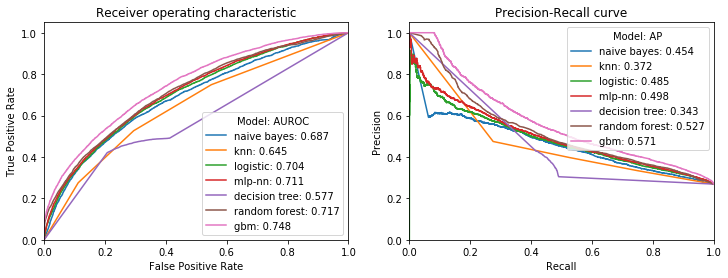

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in Pb.columns:
    roc_auc = roc_auc_score(ytest, Pb[column])
    fpr, tpr, _ = roc_curve(ytest, Pb[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, Pb[column])
    ave_prec_rec = average_precision_score(ytest, Pb[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

### Fit important variables into the models

In [20]:
Xtrain2 = df_train[important_vars]
Xtest2 = df_test[important_vars]
ytrain_original = df_train['svc_AOA_ip_30days_postdc_bi']


In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtrain2_scaled = scaler.fit_transform(Xtrain2)
Xtest2_scaled = scaler.fit_transform(Xtest2)

In [22]:
# Class Imbalance Processing: Using re-sampling method
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=SEED)
Xtrain2_scaled, ytrain = sm.fit_sample(Xtrain2_scaled, ytrain_original)

In [23]:
models = get_models()
Pm, Sm, model_cvsm = train_predict(models, Xtrain2_scaled, ytrain, Xtest2_scaled)
evaluate(ytest, Sm, Pm)

Fitting models.
naive bayes... Time elapsed  0:00:00.077792
done
knn... Time elapsed  0:00:30.993568
done
logistic... Time elapsed  0:00:00.826340
done
mlp-nn... Time elapsed  0:01:03.505622
done
decision tree... Time elapsed  0:00:01.633176
done
random forest... Time elapsed  0:00:25.222642
done
gbm... Time elapsed  0:00:34.086001
done
Done.

Accuracy : 0.7002
Precision : 0.4475
Recall : 0.4857
F1 score : 0.4658
AUC score : 0.6790
AP score : 0.4541

Classification report : 
               precision    recall  f1-score   support

           0       0.80      0.78      0.79     15338
           1       0.45      0.49      0.47      5646

    accuracy                           0.70     20984
   macro avg       0.63      0.63      0.63     20984
weighted avg       0.71      0.70      0.70     20984


Confusion matrix : 
 [[11952  3386]
 [ 2904  2742]]
done.

Accuracy : 0.6108
Precision : 0.3468
Recall : 0.5055
F1 score : 0.4114
AUC score : 0.5995
AP score : 0.3301

Classification report :

(0.39320434616850936,
 0.2946392350043466,
 0.9004605030109812,
 0.44399807868652025,
 0.66639224457261,
 0.45357345311522623)

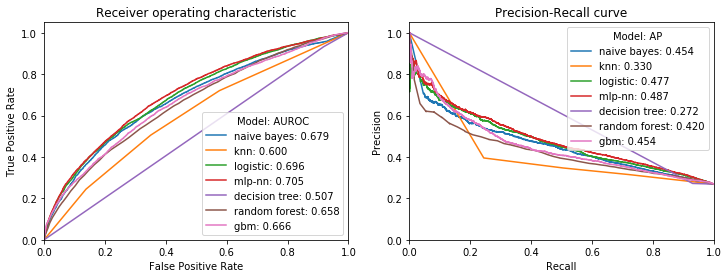

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in Pm.columns:
    roc_auc = roc_auc_score(ytest, Pm[column])
    fpr, tpr, _ = roc_curve(ytest, Pm[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, Pm[column])
    ave_prec_rec = average_precision_score(ytest, Pm[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

From the above results, I selected Gradient Boosting as my main model and the set of variables from the Boruta algorithms

## GBM tuning

In [25]:
param1 = {
    "n_estimators":[100,500,1000,1500],
    "learning_rate":[1, 0.1, 0.01, 0.001]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=SEED), 
            param_grid = param1, scoring='roc_auc',n_jobs=-1, cv=5)
tuning.fit(Xtrainb_scaled,ytrain)


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=4,
                                                  max_features='sqrt',
                                                  random_state=300,
                                                  subsample=1),
             n_jobs=-1,
             param_grid={'learning_rate': [1, 0.1, 0.01, 0.001],
                         'n_estimators': [100, 500, 1000, 1500]},
             scoring='accuracy')

In [26]:
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.1, 'n_estimators': 1500}, 0.810574623541207)

In [27]:
param2 = {
   'max_depth':[2,3,4,5,6,7]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.1,n_estimators=1000, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=SEED), 
            param_grid = param2, scoring='roc_auc',n_jobs=-1, cv=5)
tuning.fit(Xtrainb_scaled,ytrain)
tuning.best_params_, tuning.best_score_

({'max_depth': 6}, 0.8107863002020388)

In [28]:
new=GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, max_depth=5, max_features='sqrt' , random_state=SEED)
new.fit(Xtrainb_scaled,ytrain)


GradientBoostingClassifier(max_depth=5, max_features='sqrt', n_estimators=1000,
                           random_state=300)

In [29]:
y_pred=new.predict(Xtestb_scaled)
y_pred_proba = new.predict_proba(Xtestb_scaled)[:, 1]
y_true = ytest
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_proba)
ap = average_precision_score(y_true, y_pred_proba)
print ("Accuracy : {:.4f}".format(acc))
print("Precision : {:.4f}".format(precision))
print("Recall : {:.4f}".format(recall))
print("F1 score : {:.4f}".format(f1score))
print("AUC score : {:.4f}".format(auc))
print("AP score : {:.4f}".format(ap))
print("\nClassification report : \n", classification_report(y_true, y_pred))
print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))

Accuracy : 0.7712
Precision : 0.6441
Recall : 0.3346
F1 score : 0.4404
AUC score : 0.7485
AP score : 0.5815

Classification report : 
               precision    recall  f1-score   support

           0       0.79      0.93      0.86     15338
           1       0.64      0.33      0.44      5646

    accuracy                           0.77     20984
   macro avg       0.72      0.63      0.65     20984
weighted avg       0.75      0.77      0.74     20984


Confusion matrix : 
 [[14294  1044]
 [ 3757  1889]]


as_length_IP                                            0.418163
IP_history                                              0.182836
svc_pre                                                 0.141882
svc_AOA_ip_60days_pre                                   0.079436
svc_pre_all                                             0.050925
svc_AOA_ip_30days_pre                                   0.024550
sexorient_Missing/Not Reported                          0.014554
as_close_IMD/MHRC                                       0.012176
co                                                      0.011548
loc1_pre_None                                           0.011160
as_close_Psychiatric Hospital                           0.010487
dx_group_Depressive Disorders                           0.009711
as_loc_IPFFS                                            0.007933
educ_Unknown/Not Reported                               0.007081
dx_group_Schizophrenia and Other Psychotic Disorders    0.007050
as_close_Required Lower L

Text(0, 0.5, 'Feature Importance Score')

C:\Users\Andy\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Andy\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


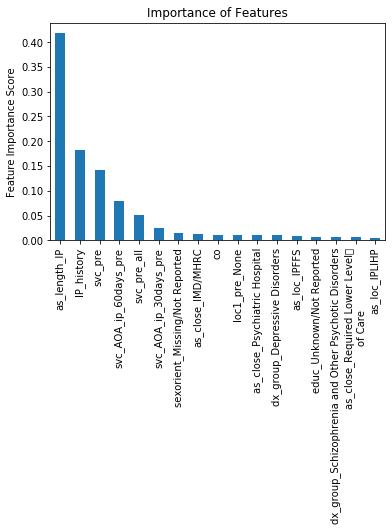

In [30]:
predictors=Xtrainb.columns
feat_imp = pd.Series(new.feature_importances_, predictors).sort_values(ascending=False)
print(feat_imp)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')


In [10]:
models = get_models()
Pb, Sb, model_cvsb = train_predict(models, Xtrainb_scaled, ytrain, Xtestb_scaled)
lr_importances = pd.Series(model_cvsb['logistic'].coef_[0], index=Xtrainb.columns, name = 'LR')
lr_importances_abs = pd.Series(abs(model_cvsb['logistic'].coef_[0]), index=Xtrainb.columns, name = 'LR')
print(lr_importances)

Fitting models.
logistic... Time elapsed  0:00:01.788003
done
Done.

as_length_IP                                           -3.204945
IP_history                                              4.750701
svc_pre_all                                            -1.945354
svc_pre                                                -3.565216
svc_AOA_ip_30days_pre                                   1.638867
svc_AOA_ip_60days_pre                                   3.089667
dx_group_Depressive Disorders                          -0.263543
dx_group_Schizophrenia and Other Psychotic Disorders    0.158161
educ_Unknown/Not Reported                              -0.299842
sexorient_Missing/Not Reported                         -0.346334
as_loc_IPFFS                                            0.146613
as_loc_IPLIHP                                          -0.383628
as_close_IMD/MHRC                                      -2.970572
as_close_Psychiatric Hospital                           1.939417
loc1_pre_None        

max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.\
min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.\
gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.\
subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.\
scale_pos_weight = 1: Because of high class imbalance.

### Archive codes

In [31]:
'''
# impute missing values of categorical features with the most frequent object
for col in categorical_features:
    df[col].fillna(df[col].value_counts().index[0], inplace=True)
'''

'\n# impute missing values of categorical features with the most frequent object\nfor col in categorical_features:\n    df[col].fillna(df[col].value_counts().index[0], inplace=True)\n'

In [32]:
'''
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
'''

"\ngsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,\n min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \n param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)\n"

In [33]:
'''
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',silent=True, nthread=4, 
                    scale_pos_weight=1, random_state=SEED)
grid_search = GridSearchCV(xgb, param_grid = parameters, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
grid_search.fit(Xtrainb_scaled, ytrain)

# retrieve the best parameter set from grid search
print("\nGrid Search Best parameters set :")
print(grid_search.best_params_)
print("\nBest score: %0.3f" % grid_search.best_score_)
time_elapsed = (time.monotonic()-start_time)/60
print("Calculation took %.3f minutes" % time_elapsed)

'''

'\nxgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective=\'binary:logistic\',silent=True, nthread=4, \n                    scale_pos_weight=1, random_state=SEED)\ngrid_search = GridSearchCV(xgb, param_grid = parameters, scoring=\'roc_auc\', n_jobs=4, iid=False, cv=5)\ngrid_search.fit(Xtrainb_scaled, ytrain)\n\n# retrieve the best parameter set from grid search\nprint("\nGrid Search Best parameters set :")\nprint(grid_search.best_params_)\nprint("\nBest score: %0.3f" % grid_search.best_score_)\ntime_elapsed = (time.monotonic()-start_time)/60\nprint("Calculation took %.3f minutes" % time_elapsed)\n\n'

In [34]:
'''
def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        ap = average_precision_score(y, P.loc[:, m])
        print("%-26s: %.3f, %.3f" % (m, score, ap))
    print("Done.\n")
    
def report_models(S, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        report = classification_report(y, S.loc[:, m])
        print(report)
    print("Done.\n")

'''

'\ndef score_models(P, y):\n    """Score model in prediction DF"""\n    print("Scoring models.")\n    for m in P.columns:\n        score = roc_auc_score(y, P.loc[:, m])\n        ap = average_precision_score(y, P.loc[:, m])\n        print("%-26s: %.3f, %.3f" % (m, score, ap))\n    print("Done.\n")\n    \ndef report_models(S, y):\n    """Score model in prediction DF"""\n    print("Scoring models.")\n    for m in P.columns:\n        report = classification_report(y, S.loc[:, m])\n        print(report)\n    print("Done.\n")\n\n'

In [35]:
'''
param3 = {
   'min_samples_split':[4,8,10,20,40,60,80,100], 
    'min_samples_leaf':[1,3,5,7,9]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, subsample=1,max_features='sqrt', random_state=SEED), 
            param_grid = param3, scoring='accuracy',n_jobs=-1, iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

'''

"\nparam3 = {\n   'min_samples_split':[4,8,10,20,40,60,80,100], \n    'min_samples_leaf':[1,3,5,7,9]\n}\n\ntuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, subsample=1,max_features='sqrt', random_state=SEED), \n            param_grid = param3, scoring='accuracy',n_jobs=-1, iid=False, cv=5)\ntuning.fit(X_train,y_train)\ntuning.grid_scores_, tuning.best_params_, tuning.best_score_\n\n"